In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans

import pickle

In [2]:
sns.set(rc={'figure.figsize':(10,5)})

In [3]:
CENSUS_PATH = 'data/refined/census_data.parquet'

CUSTOMER_PATH = 'data/refined/customer_data.parquet'

In [4]:
census = pd.read_parquet(CENSUS_PATH)

In [5]:
census.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,...,KBA13_ALTERHALTER_45,KBA13_SEG_VAN,KBA13_BJ_2004,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET
1,910220,11.0,0.0,2.0,0.0,963.0,1992.0,0.0,0.0,0.0,...,2.0,4.0,3.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0
2,910225,10.0,0.0,1.0,0.0,712.0,1992.0,0.0,0.0,0.0,...,2.0,3.0,4.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0
3,910226,1.0,0.0,0.0,0.0,596.0,1997.0,0.0,0.0,0.0,...,3.0,4.0,3.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0
4,910241,3.0,0.0,4.0,0.0,435.0,1992.0,1.0,1.0,0.0,...,3.0,2.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0
5,910244,5.0,0.0,1.0,0.0,1300.0,1992.0,0.0,0.0,0.0,...,4.0,4.0,3.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0


In [6]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [7]:
census_var_types.head()

,Attribute,Type
0,ALTERSKATEGORIE_GROB,interval
1,ANREDE_KZ,binary
2,ANZ_HAUSHALTE_AKTIV,numeric
3,ANZ_HH_TITEL,numeric
4,ANZ_PERSONEN,numeric


In [8]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [9]:
census.shape

(784908, 172)

In [10]:
census_var_types['Type'].value_counts()

interval    166
nominal      14
numeric       7
binary        6
Name: Type, dtype: int64

Variables considered as interval could be used in PCA. Unfortunately, this approach is not enough to handle nominal and binary features.  
An alteranitve approach to solve this problem is [Factorial Analysis of Mixed Data (FAMD)](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210).  
Using this approach, we will reduce the dimensions of the mixed data types prior to clustering it.

# Clustering demographic data

## Adjustments to nominals and binaries

In [11]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [12]:
for col in binary_vars:
    
    try:
        print(col, census[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [13]:
census['ANREDE_KZ'] = census['ANREDE_KZ'] - 1

census['VERS_TYP'] = census['VERS_TYP'] - 1

## Subsetting dataframe

In [14]:
is_subset = True

if is_subset:

    with open('data/trusted/selected_features.pkl', 'rb') as file:

        selected_features = pickle.load(file)
    
    selected_features.append('LNR')

    census = census[selected_features].copy()

In [15]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, census.columns)

In [16]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, census.columns)

In [17]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [18]:
num_cols = census.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR'])

In [19]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == census.shape[1]

# PCA + KMeans
- FAMD Implementation
- Using K-Means so we can leverage the centroid position to predict the populations' clusters without necessarily having to cluster the whole population

In [20]:
census = pd.get_dummies(census, columns=list(nominal_vars))

In [21]:
dummy_nominal_vars = []

for name in list(nominal_vars):

    for col in census.columns:

        if name in col:

            dummy_nominal_vars.append(col)

# Fix for GEBAEUDETYP and GEBAUDETYP_RASTER
dummy_nominal_vars = sorted(list(set(dummy_nominal_vars)))

In [22]:
def weight_encoded_col(col):

    '''
    Generates weights according to FAMD implementation. Works in binary variables.
    The weight is given as the division of the 1 values by the square-root of the probability of occurance of the effect in the column.

    :param col: column to be adjusted

    :return col: column after adjustments
    '''

    # mean = probability of occurance for a binary col
    mean = col.mean()

    weight = np.sqrt(mean)

    col = col / weight
    
    # Centering
    center_ref = col.mean()

    col = col - center_ref
    
    return col

In [23]:
for col in list(binary_vars) + list(dummy_nominal_vars):

    census[col] = weight_encoded_col(census[col])

## Numerical columns

In [24]:
num_col_list = census.columns.drop(list(binary_vars) + dummy_nominal_vars + ['LNR'])

In [25]:
scaler = StandardScaler()

In [26]:
census[num_col_list] = scaler.fit_transform(census[num_col_list])

# PCA

In [27]:
census.shape

(784908, 105)

**Warning: Running the cell below might take a while. Beware of that**

In [35]:
explained_var_list_step_2 = []

for comp in range(20,100, 20):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}', end = '\n\n')
    
    explained_var_list_step_2.append(expl_variance)

    if expl_variance >= 0.95:

        break
    # explained_var_list.append(explained_var_list_step_2)

Running for 20 components...
Explained Variance: 0.5790538237983482

Running for 40 components...
Explained Variance: 0.7848555044809882

Running for 60 components...
Explained Variance: 0.9221030932841603

Running for 80 components...
Explained Variance: 0.98239744905113



# K-Means

800k entries is too much for some machines to handle and/or take a long time for the algorithm to run.  
Therefore, assuming the AZDIAS data as the population we want to model for, we will use a sample of it to find the centroids of our clusters to then propagate this information.  
Using a simple [Sample Size Calculator](https://www.calculator.net/sample-size-calculator.html?type=1&cl=99.9&ci=1&pp=50&ps=891221&x=0&y=0), assuming a homogenous population we can find that starting from 5000 random samples we can have a good enough representation of the general population.

In [28]:
def score_kmeans(X,k_range):

    '''
    Function that iteratively scores K-Means based on point distance to centroids.

    :param X: Data that the Kmeans should be fitted to
    :param k_range: range to be used for experimentation.

    :return dist_list: List of total inertia for each step in the ranges
    '''

    for i, k in enumerate(k_range):

        print(f'Running for K = {k} Clusters...')

        # Using MiniBatch for performance
        kmeans = MiniBatchKMeans(n_clusters=k,
                                    init = 'k-means++',
                                    random_state=123,
                                    batch_size=2048,
                                    max_iter=50,
                                    n_init = 3)

        kmeans.fit(X)

        if i == 0:

            dist_list = [kmeans.inertia_]
        
        else:

            dist_list.append(kmeans.inertia_)

    return dist_list

In [29]:
pca = PCA(n_components=70, random_state=123)

pca.fit(census.drop(columns = 'LNR'))

X = pca.transform(census.drop(columns = 'LNR'))

In [30]:
rng = np.random.default_rng()

# Reproducibility
np.random.seed = 123

X_sample = rng.choice(X, size = 10000, replace = False)

In [31]:
k_range = range(2,11)

In [32]:
distances = score_kmeans(X_sample, k_range)

Running for K = 2 Clusters...
Running for K = 3 Clusters...
Running for K = 4 Clusters...
Running for K = 5 Clusters...
Running for K = 6 Clusters...
Running for K = 7 Clusters...
Running for K = 8 Clusters...
Running for K = 9 Clusters...
Running for K = 10 Clusters...


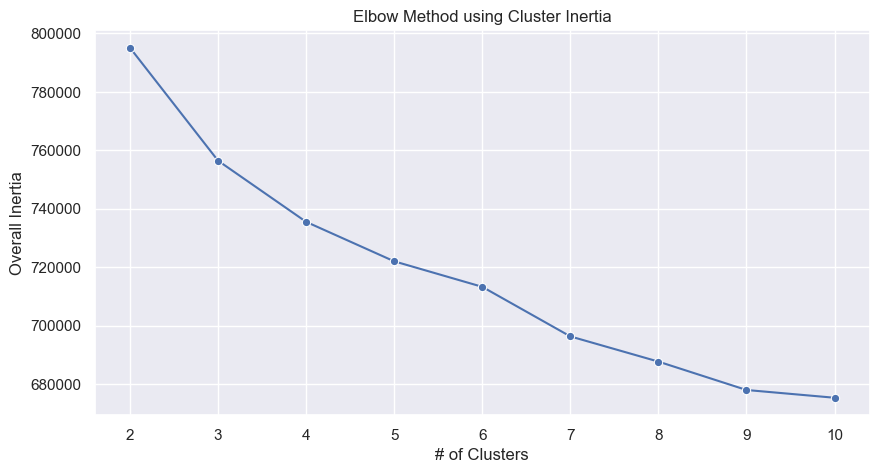

In [41]:
sns.lineplot(x = range(2,len(distances) + 2),
             y = distances,
             marker = 'o')

plt.xlabel('# of Clusters')

plt.ylabel('Overall Inertia')

plt.title('Elbow Method using Cluster Inertia')

plt.show()

Using the Elbow Method we can choose 9 as an appropriate number of clusters

## Instantiating selected clustering method

In [43]:
kmeans_model = MiniBatchKMeans(n_clusters=9,
                                init = 'k-means++',
                                random_state=123,
                                batch_size=2048,
                                max_iter=50,
                                n_init = 3)

kmeans_model.fit(X_sample)

MiniBatchKMeans(batch_size=2048, max_iter=50, n_clusters=9, n_init=3,
                random_state=123)

In [45]:
# with open('models/demographic_clusters.pkl','wb') as file:

#     pickle.dump(kmeans_model, file)

# Comparing Datasets

## Customer data Preprocessing

In [46]:
customers = pd.read_parquet('data/refined/customer_data.parquet')

In [49]:
customers = customers[selected_features].copy()

In [50]:
# Preprocessing customers data like we did census data
customers = pd.get_dummies(customers, columns=list(nominal_vars))

for col in list(binary_vars) + list(dummy_nominal_vars):

    customers[col] = weight_encoded_col(customers[col])

customers[num_col_list] = scaler.fit_transform(customers[num_col_list])

In [52]:
X_cust = pca.transform(customers.drop(columns = 'LNR'))

In [54]:
customers['cluster'] = kmeans_model.predict(X_cust)

In [56]:
census['cluster'] = kmeans_model.predict(X)

## Plotting Comparison

In [94]:
cluster_prop_plot = pd.concat([customers['cluster'].value_counts(normalize = True),
                                census['cluster'].value_counts(normalize = True)],
                                axis = 1)

cluster_prop_plot.columns = ['customers','azdias']

cluster_prop_plot = cluster_prop_plot.melt(ignore_index=False)

cluster_prop_plot.reset_index(inplace = True)

# cluster_prop_plot

In [100]:
import matplotlib.ticker as mtick

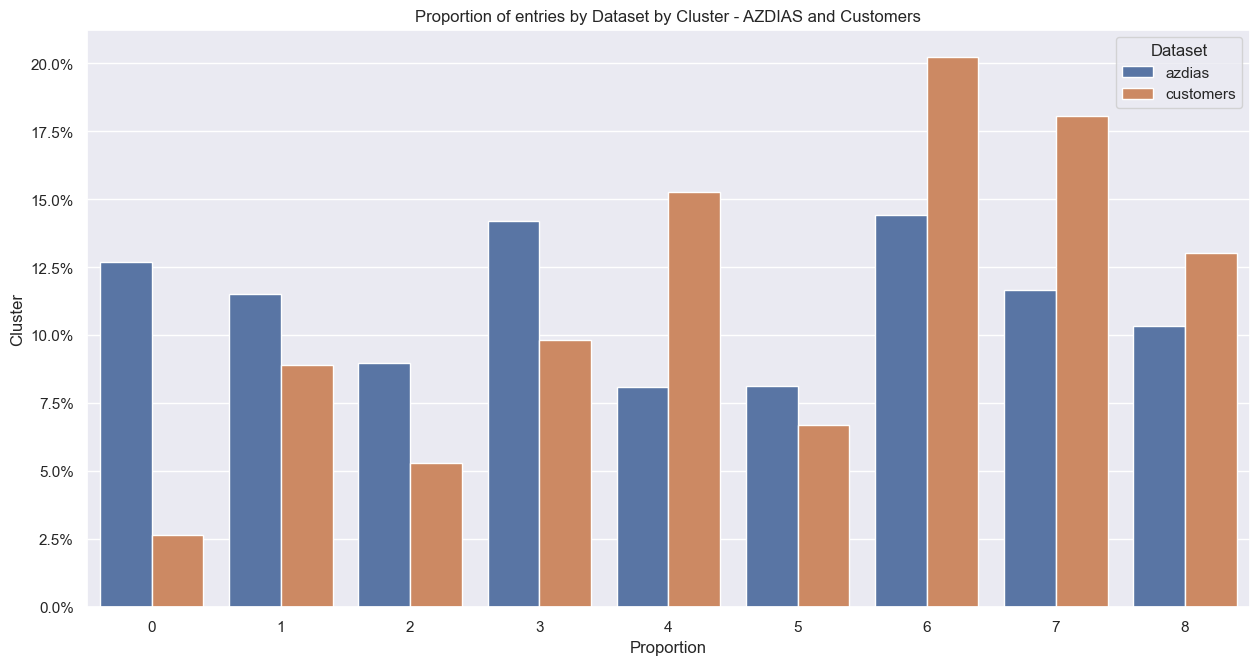

In [109]:
fig, ax = plt.subplots(figsize = (15,7.5))

g = sns.barplot(
                    data = cluster_prop_plot,
                    x = 'index',
                    y = 'value',
                    hue = 'variable',
                    hue_order=['azdias','customers'],
                    ax = ax
                )

g.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.title('Proportion of entries by Dataset by Cluster - AZDIAS and Customers')

plt.xlabel('Proportion')

plt.ylabel('Cluster')

plt.legend(title = 'Dataset')

plt.show()

As we can see from the plot. It looks like the clusters 4, 6, 7 and 8 are those who concentrate more customers profile. People that are assigned in those clusters are more likely to turn into potential leads.  

Let's dig a little deeper on the 4 and 6 clusters since:
- 4 has proportionally double the amount of records in the customer data then in azdias data and;
-  6 since it's the proportionally biggest cluster for the customer data.

## Cluster interpretations

In [191]:
def get_main_components(cluster_model = kmeans_model, n_largest = 5, cluster_id = 0, return_frame = False):

    '''
    Lists main components for a given cluster in 'cluster_id' in a given model. A main component is considered a component that is centered away from 0 in either direction (positive or negative).
    Defaults to the 5 largest distances from 0.
    To work, the clustering method needs to have distance-based centroids.

    :param cluster_model: Clustering model (WITH CENTROIDS) to be evaluated for components.
    :param n_largest: Number of components to return for a cluster
    :param cluster_id: Id (index) of the cluster
    :param return_frame: Boolean to define if whole dataframe needs to be returned.
    
    :return temp: Full dataframe with components' coordinates
    :return main_components: Frame with only the n_largest defined amount of componets
    '''

    temp = pd.DataFrame(cluster_model.cluster_centers_[cluster_id],
                        columns=['component_coordinate'])
    
    temp['abs_comp_coordinate'] = temp['component_coordinate'].abs()

    if return_frame:

        return temp
    
    else:

        main_components = temp.nlargest(columns = 'abs_comp_coordinate', n = n_largest)

    return main_components

def describe_component(component_id, base_df = census, n_features = 10, pca_object = pca, return_frame = False):

    '''
    Describes a component within the PCA. Defaults to the 10 features with largest ABSOLUTE indices.

    :param component_id: Id (index) of the component
    :param base_df: Frame with the column names used in the PCA
    :param n_features: Amount of features to be extracted - Defaults to 10
    :param pca_object: PCA fitted on the base_df
    :param return_frame: Boolean that indicates if the whole variable list of indices should be returned

    :return weights_frame: Complete frame with all indices by variable:
    :return weights_frame.nlargest: Frame subsetted to only n biggest absolute indices
    '''

    base_dict = dict(zip(base_df.columns.drop('cluster'),
                         pca.components_[component_id]))
    
    weights_frame = pd.DataFrame.from_dict(base_dict, orient = 'index', columns = ['pca_weight'])

    if return_frame:

        return weights_frame
    
    else:

        weights_frame['abs_pca_weight'] = weights_frame['pca_weight'].abs()

        return weights_frame.nlargest(n_features, columns = 'abs_pca_weight')

In [193]:
for i, cluster_id in enumerate([4,6]):

    main_comps = get_main_components(cluster_id=cluster_id)

    print(f'Cluster {cluster_id} main components:')

    display(main_comps)

Cluster 4 main components:


,component_coordinate,abs_comp_coordinate
0,1.728778,1.728778
1,-1.413436,1.413436
4,-1.082348,1.082348
7,-1.026743,1.026743
8,0.653640,0.653640


Cluster 6 main components:


,component_coordinate,abs_comp_coordinate
1,4.184858,4.184858
0,-0.524761,0.524761
9,-0.414880,0.414880
4,0.377505,0.377505
6,-0.360164,0.360164


The components 0 and 1 dominate both clusters, even though cluster 6 is more heavily centered around PC 1 and cluster 4 has a more balanced relationship between both variables.  
Also, it is worth to note that the signal for both Components are different.

In [197]:
for comp in [0,1]:

    print(f'Top 10 Main features for Component {comp}:')
    
    temp = describe_component(component_id = comp)

    display(temp.style.background_gradient(subset = 'pca_weight'))

    print(end = '\n\n')

Top 10 Main features for Component 0:


,pca_weight,abs_pca_weight
CJT_TYP_2,0.240268,0.240268
FINANZ_SPARER,0.235902,0.235902
CJT_TYP_1,0.235577,0.235577
PRAEGENDE_JUGENDJAHRE,0.230985,0.230985
FINANZ_VORSORGER,-0.223019,0.223019
CJT_TYP_5,-0.219320,0.219320
ALTERSKATEGORIE_GROB,-0.211331,0.211331
CJT_TYP_3,-0.210833,0.210833
CJT_TYP_6,-0.203913,0.203913
SEMIO_PFLICHT,0.202693,0.202693




Top 10 Main features for Component 1:


,pca_weight,abs_pca_weight
D19_VERSAND_DATUM,-0.300445,0.300445
D19_GESAMT_ANZ_12,0.295204,0.295204
D19_GESAMT_DATUM,-0.294172,0.294172
D19_VERSAND_ANZ_12,0.284418,0.284418
ONLINE_AFFINITAET,0.266443,0.266443
LP_LEBENSPHASE_GROB,0.224899,0.224899
D19_GESAMT_ONLINE_QUOTE_12,0.203568,0.203568
CJT_GESAMTTYP_6.0,0.201215,0.201215
D19_VERSAND_ONLINE_QUOTE_12,0.194292,0.194292
D19_KONSUMTYP_6.0,-0.188178,0.188178


Component 0:
- is heavily centered around Customer Journey definitions. Even within customer journeys, it segments the population.  
- Has a strong relationship to "dutyfull traditional minded" persons (SEMIO_PFLICHT)
- Has a strong relationship to the dominating movement in a persons youth (PRAEGENDE_JUGENDJAHRE)
- Focuses on Moneysavers that are not necessairly prepared (FINANZ_SPARER - positive sign and FINANZ_VORSORGER - negative sign)

**Component 0 can be understood as a component that describes the general consumption journey of different generations and their financial decisions**

Component 1:
- Heavily influenced by transaction activity (_DATUM and _ANZ cols)
- Considers the person online affinty (ONLINE_AFFINITAET and _QUOTE cols)
- Considers the persons life-phase (LP_LEBENSPHASE_GROB)
- Focuses on modern consumers (D19_KONSUMTYP_6.0) that are ad enthusiasts byt don't show cross-channel adherence (CJT_GESAMTTYP_6.0)

**Component 1 can be seen as a component that quantifies the consumpion patterns especially for modern consumers**